In [1]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil

from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [2]:
a = 1

In [3]:
_NOISE_DIM = 4
_H_FILTERS = 2

In [4]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [5]:
get_num_params(G)

3256

In [6]:
get_num_params(D)

768

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.5735 +/- 0.0823


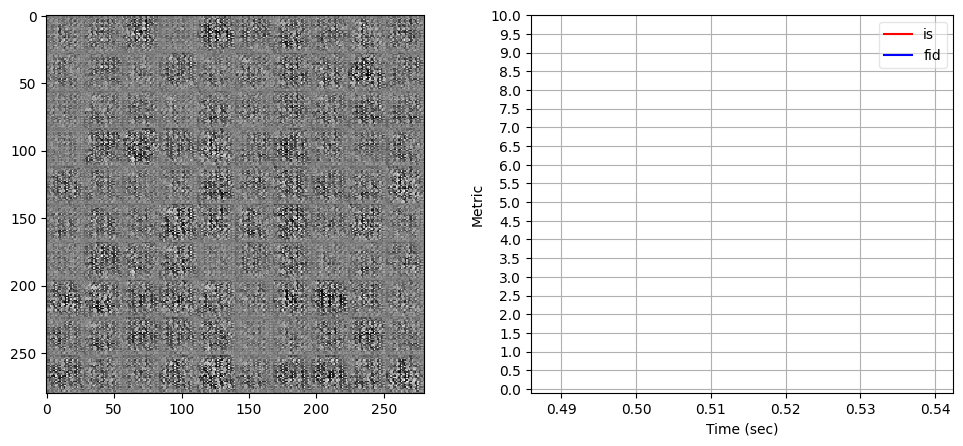

Iter 5000: Mean proba from D(G(z)): 0.4987 +/- 0.0018


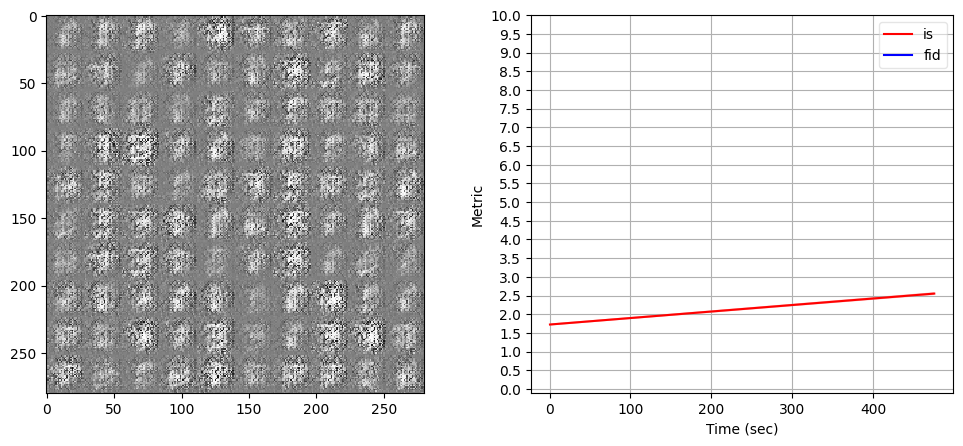

Iter 10000: Mean proba from D(G(z)): 0.5003 +/- 0.0224


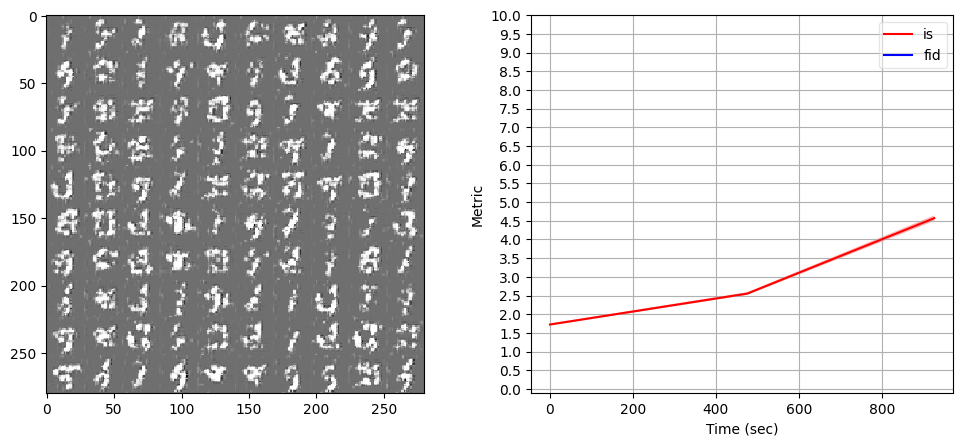

Iter 15000: Mean proba from D(G(z)): 0.5004 +/- 0.0134


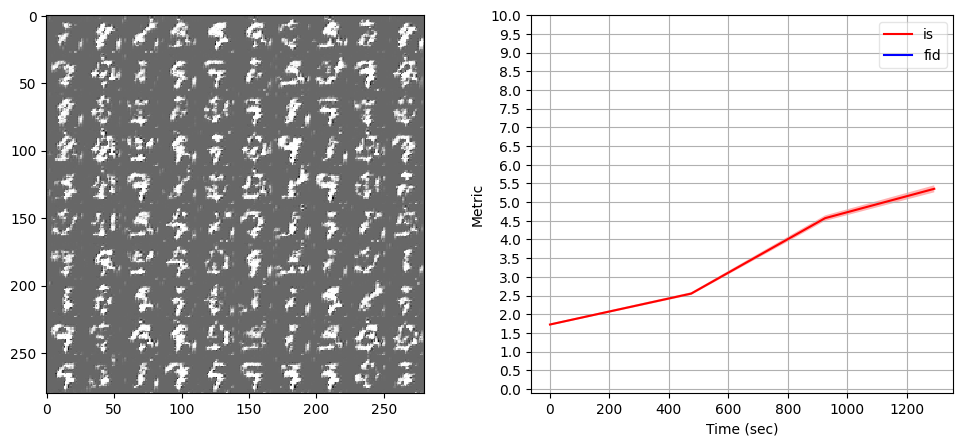

Iter 20000: Mean proba from D(G(z)): 0.4990 +/- 0.0046


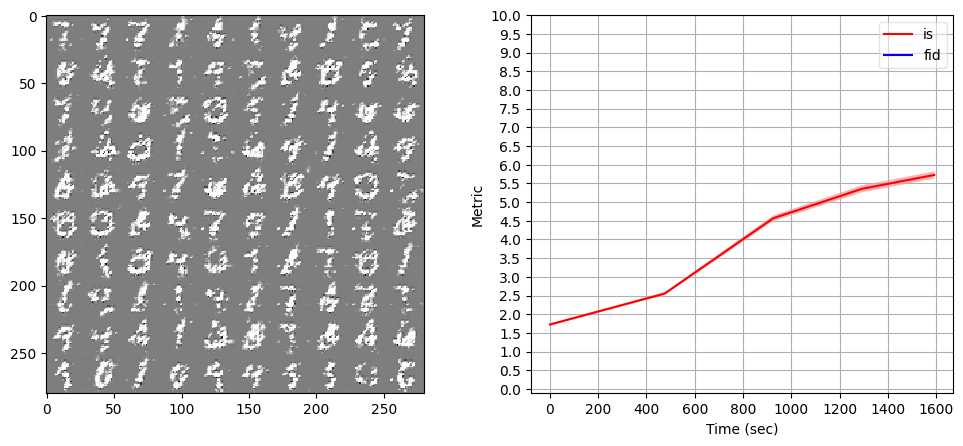

Iter 25000: Mean proba from D(G(z)): 0.5011 +/- 0.0080


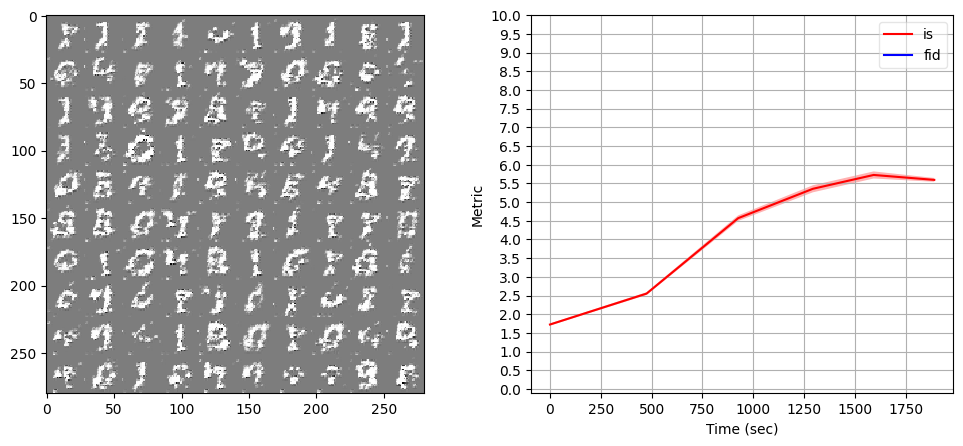

Iter 30000: Mean proba from D(G(z)): 0.4514 +/- 0.0259


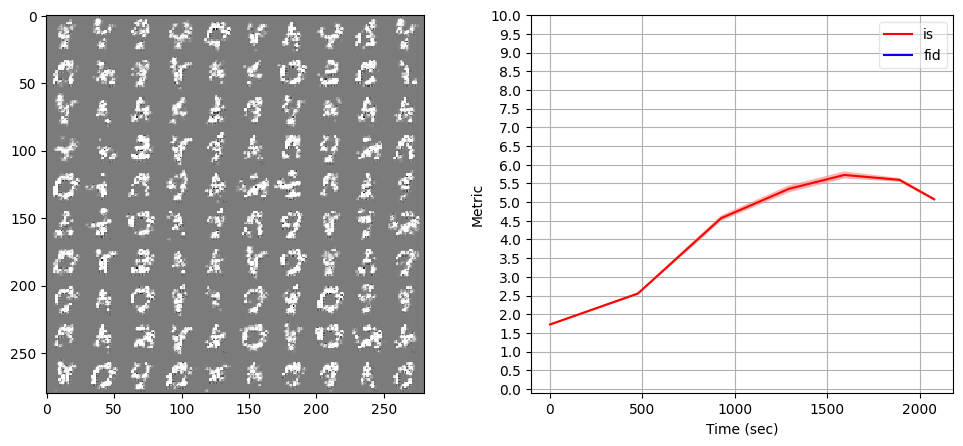

Iter 35000: Mean proba from D(G(z)): 0.4637 +/- 0.0686


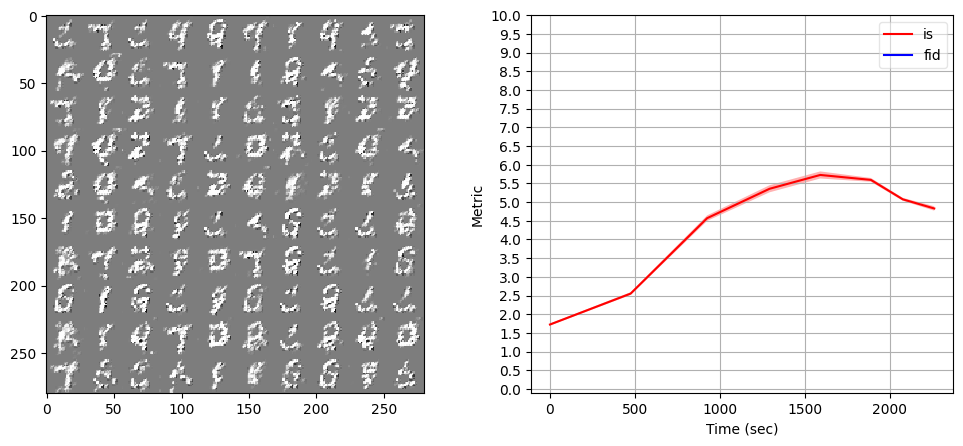

Iter 40000: Mean proba from D(G(z)): 0.4582 +/- 0.0600


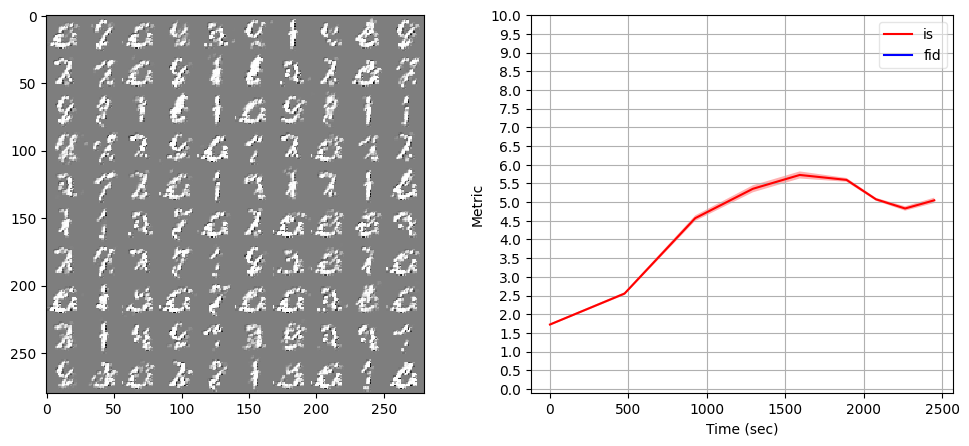

Iter 45000: Mean proba from D(G(z)): 0.3883 +/- 0.0876


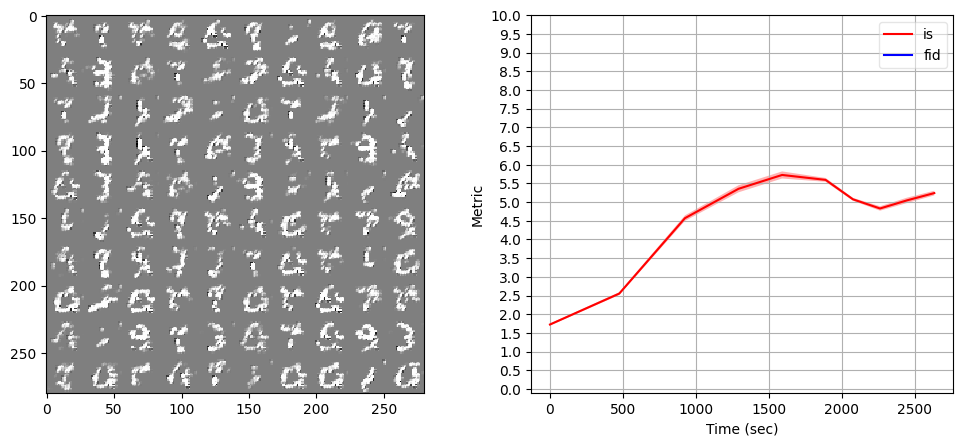

In [ ]:
args = dict(iterations = 100000,
            batch_size = 1024,
            lrD = 0.001,
            lrG = 0.001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}_beta1{args['beta1']}_lookahead{args['lookahead']}" + \
            f"_lak{args['lookahead_k']}" + \
            f"_extragrad{args['extragrad']}_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lookahead=args['lookahead'],
        lookahead_k=args['lookahead_k'],
        eval_avg=args['eval_avg'],
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        beta1=args['beta1'], 
        extragrad=args['extragrad'],
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        grad_max_norm=args['grad_max_norm'], 
        plot_func=plot_func,
        out_dir=out_dir)